<a href="https://colab.research.google.com/github/cliffchan0918/cryptotrade/blob/main/crypto_trade_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib

In [ ]:
import requests
#importing data from url with list of cryptos info
headers = {
    'x-api-key' : "SwW0Mt7bUi12i310pjeAaayb2KQ99GP41EPANKO0",
}
list_url='https://83i8cudoh7.execute-api.ap-east-1.amazonaws.com/dev/cryptos'

#get the crypto_id 
list_info = requests.get(list_url, headers=headers).json()
crypto_id = pd.json_normalize(list_info,'data')
crypto_id

In [45]:
api_url = "https://83i8cudoh7.execute-api.ap-east-1.amazonaws.com/dev/crypto/"
prod_url = []
for i in crypto_id['product_id']:
    prod_url.append(f'{api_url}{i}')

#get the info of respective cryptos with its crypto_id
eth = requests.get(prod_url[0],headers=headers).json()
btc = requests.get(prod_url[1],headers=headers).json()
usdc = requests.get(prod_url[2],headers=headers).json()

#get the daily return of respective cryptos and save it as pandas DataFrame format
btc_d = pd.DataFrame(btc['data']['dod']).T
eth_d = pd.DataFrame(eth['data']['dod']).T
usdc_d = pd.DataFrame(usdc['data']['dod']).T

#get the monthly return of respective cryptos and save it as pandas DataFrame format
btc_m = pd.DataFrame(btc['data']['mom']).T
eth_m = pd.DataFrame(eth['data']['mom']).T
usdc_m = pd.DataFrame(usdc['data']['mom']).T

In [46]:
import numpy as np
import pandas as pd
#merging the monthly data of cryptos and renaming the columns
basedata = pd.DataFrame(data=btc_m,index=btc_m.index)
basedata = basedata.rename(columns={'amount':'BTC_close','converted_date':'date','mom':'BTC_return'})
newdata = pd.DataFrame(data=eth_m,index=eth_m.index)
newdata = newdata.rename(columns={'amount':'ETH_close','converted_date':'date','mom':'ETH_return'})
basedata = pd.merge(basedata, newdata, on='date')
newdata2 = pd.DataFrame(data=usdc_m,index=usdc_m.index)
newdata2 = newdata2.rename(columns={'amount':'USDC_close','converted_date':'date','mom':'USDC_return'})
basedata = pd.merge(basedata, newdata2, on='date')
basedata['date'] = pd.to_datetime(basedata['date'])
basedata.set_index([basedata['date']], inplace = True)
basedata = basedata[['date','BTC_close','BTC_return','ETH_close','ETH_return','USDC_close','USDC_return']]
basedata.replace(0, np.nan, inplace=True)
#merging the daily data of cryptos and renaming the columns
base = pd.DataFrame(data=btc_d,index=btc_d.index)
base = base.rename(columns={'amount':'BTC_close','converted_date':'date'})
base['BTC_log_ret'] = np.log((base['dod']+1).astype('float'))
base.drop(['dod'],axis=1)
new = pd.DataFrame(data=eth_d,index=eth_d.index)
new = new.rename(columns={'amount':'ETH_close','converted_date':'date'})
new['ETH_log_ret'] = np.log((new['dod']+1).astype('float'))
new.drop(['dod'],axis=1)
new2 = pd.DataFrame(data=usdc_d,index=usdc_d.index)
new2 = new2.rename(columns={'amount':'USDC_close','converted_date':'date','dod':'USDC_ret'})
base = pd.merge(base, new, on='date')
base = pd.merge(base, new2, on='date')
base.set_index(base['date'],inplace=True)
base = base[['BTC_close','BTC_log_ret','ETH_close','ETH_log_ret','USDC_close','USDC_ret']]
base.replace(0, np.nan, inplace=True)

In [283]:
#getting the history price of cryptos for last 30 days
hist_price_list = pd.DataFrame(base[['BTC_close',"ETH_close","USDC_close"]])
#getting the returns of cryptos and normalize it to log return for last 30 days
log_return2 = pd.DataFrame(data = base[['BTC_log_ret','ETH_log_ret']])
#find out optimal weights using last 6 months results
last_6_months = basedata.iloc[-8:-2]
last_6_months = last_6_months[['BTC_return','ETH_return']]
last_6_months['BTC_return'] = np.log((last_6_months['BTC_return']+1).astype('float'))
last_6_months['ETH_return'] = np.log((last_6_months['ETH_return']+1).astype('float'))

#get the average daily return of last 6 months for initializing the daily return
last_month = last_6_months
last_month = last_month.div(120)
init_return = pd.DataFrame(columns=last_month.columns)
init_return = init_return.append(last_month) 
init_return = init_return.rename(columns={'BTC_return':'BTC_log_ret','ETH_return':'ETH_log_ret'})

In [48]:
#the function of efficient frontier to calculate optimal weight
from scipy.optimize import minimize
def Efficient_frontier(data,period):
  meanRet = data.mean()
  sigma  = data.cov()
  def get_metrics(w) ->np.array:
    w = np.array(w)
    R = np.sum(meanRet*w)*period
    V = np.sqrt(np.dot(w.T,np.dot(sigma*period,w)))
    SR = R/V
    return np.array([R,V,SR], dtype="object")
  def neg_sharpe(w) ->np.array:
    return get_metrics(w)[2] * -1

  def volatility(w) ->np.array:
    return get_metrics(w)[1]

  def check_sum(w) ->float:
    return np.sum(w) - (1 - portfolio_reserve)

  guess = [0.5,0.5]
  bounds = tuple((0.0,1.0) for i in range(2))
  constraints = ({'type':'eq', 'fun': check_sum})
  optimized_volatility = minimize(volatility,guess,method='SLSQP',bounds=bounds,constraints=constraints)
  return optimized_volatility.x


In [120]:
#functions of Buying, Selling and creating log signal
def Buy(symbol,price,buy_amount):
  buy_amount = round(buy_amount,7)
  used_balance = price*buy_amount
  return buy_amount

def Sell(symbol,price,sell_amount):
  sell_amount = round(sell_amount,7)
  used_balance = price*sell_amount
  return sell_amount

def log(signal,symbol,amount,price,date):
  data = [date,signal,symbol,amount,price]
  if signal =='Buy':
    print(f"At {date} : Buy {amount} {symbol} @${price}")
  elif signal =='Sell':
    print(f"At {date} : Sell {amount} {symbol} @${price}")
  log_data.append(data)

In [51]:
def new_value(today_price,portfolio,t_weight):
  y = 0
  new_value = 0
  for i in range(len(today_price)):
    y += 2
    amount = float(portfolio[y])
    new_value = new_value + today_price[i]*amount
  return new_value
def target_amount(today_price,t_weight,new_value):
  new_amount = new_value*t_weight/today_price
  return new_amount

In [294]:
#the main function for determining whether to buy or sell and the respective amount
def buy_or_sell(trade_on,weights,t_price,date):
  symbol = ["Bitcoin","Ethereum","USD Coin"]
  bal_weights = weights
  bal_weights.append(portfolio_reserve)
  collect_data = []     #get that data on that day(date, price of cryptos, amount for holding cryptos)
  old_amount = []       #get previous amount holding
  collect_data.append(date)
  global save_portfolio
  yesterday_portfolio = save_portfolio.iloc[-1]
  new_val = new_value(t_price,yesterday_portfolio,weights)  #get the current value of portfolio
  y = 0
  weight_log(symbol, bal_weights)
  for i in range(len(symbol)):     #looping each cryptos in for considering buy sell option
    y += 2
    old_amount = float(yesterday_portfolio[y])
    t_amount = target_amount(t_price[i],weights[i],new_val)
    check_first_day = len(save_portfolio)       #check is it first day of backtesting, if yes than use the initial optimal weight
    if check_first_day == 1:
      in_t_amount = target_amount(t_price[i],weights[i],init_balance)
      gain_amount=Buy(symbol[i],t_price[i],in_t_amount)
      log('Buy',symbol[i],gain_amount,t_price[i],date)
      collect_data.append(t_price[i])
      collect_data.append(in_t_amount)
    else:
      if trade_on:              #to check that day whether the day able to trade
        diff_amount = t_amount - old_amount #calculate amount for buy or sell
        if diff_amount > 0.0:      
          gain_amount = Buy(symbol[i],t_price[i],diff_amount)
          log('Buy',symbol[i],gain_amount,t_price[i],date)  #printing the buy info
          collect_data.append(t_price[i])
          collect_data.append(t_amount)

        elif diff_amount < 0.0:
          diff_amount = abs(diff_amount)
          lose_amount = Buy(symbol[i],t_price[i],diff_amount)
          log('Sell',symbol[i],lose_amount,t_price[i],date) #printing the sell info
          collect_data.append(t_price[i])
          collect_data.append(t_amount)

        else:
          collect_data.append(t_price[i])
          collect_data.append(old_amount)
      else:
        collect_data.append(t_price[i])
        collect_data.append(old_amount)
  if new_val ==0:
    collect_data.append(init_balance)
  else:
    collect_data.append(new_val)
  return collect_data

In [138]:
#initializing the portfolio
def portfolio_init():
  data = pd.DataFrame(columns=[['date','BTC_price','BTC_amount','ETH_price','ETH_amount','USDC_price','USDC_amount','Total_value']])
  empty_list = ['','0.0','0.0','0.0','0.0','0.0','0.0','0.0']
  data.loc[len(data)] = empty_list
  return data
#updating new data to portfolio
def portfolio_update(df,new_list):
  new_list_series = pd.Series(new_list, index=df.columns)
  df = df.append(new_list_series, ignore_index=True)
  return df
#printing latest info of portfolio
def portfolio_log(value):
  crypto = ["Bitcoin",'Ethereum','USD Coin']
  symbol = ['BTC','ETH','USDC']
  print('-'*80)
  print(f'Portfolio weight at {value[0]}:')
  x = -1
  for i in range(len(crypto)):
    x += 2
    if value[x+1] == 0:
      print(f'{crypto[i]} Amount Held : None')
    else:
      print(f'{crypto[i]} Amount Held : {value[x+1]}{symbol[i]} at @${value[x]}')
  print(f'Total value of the portfolio = ${value[-1]}')
  print('-'*80)


In [ ]:
log_return2.iloc[3]

In [323]:

#finding optimal weight using last 6 months returns to initialize the first optimal weight
def init_opt_weight():
  data = Efficient_frontier(last_6_months,12).round(5)
  data = data.tolist()
  data = [float(i) for i in data]
  return data
def weight_log(symbol, w_list):
  i = 0
  print('*'*80)
  for x in symbol:
    per_w = round(w_list[i],5)*100.0
    if w_list[i] > 0.0:
      print(f'{x}: {per_w}%')
    i +=1
  print('*'*80)
#the main function for starting up the backtest up to last 30 days
def start_backtest(trade_per,reserve,d_range): 
  global save_portfolio, portfolio_reserve
  portfolio_reserve = reserve    
  weights = ['','']
  symbol = ["Bitcoin","Ethereum","USD Coin"]
  ret_list = pd.DataFrame(columns = ['BTC_log_ret','ETH_log_ret'])
  ret_list = ret_list.append(init_return)
  price_list = pd.DataFrame(columns = ['BTC_close',"ETH_close","USDC_close"])
  strat_on = False
  for day in range(len(base)):      #looping functions after day
    ret_list = ret_list.append(log_return2.iloc[day], ignore_index=False)
    price_list = price_list.append(hist_price_list.iloc[day], ignore_index=False)
    if day < 1:   #first trade day use the inital weight
      opt_weights_list = init_opt_weight()
    else:
      opt_weights = Efficient_frontier(ret_list,20).round(5)
      opt_weights_list = opt_weights.tolist()
      opt_weights_list = [float(i) for i in opt_weights_list]
    strat_on = True
    trade_on = False
    today_price = price_list.iloc[-1]
    today_price_list = today_price.tolist()
    today_price_list = [float(i) for i in today_price_list]
    today_date = today_price.name
    if len(ret_list) > d_range:
      ret_list = ret_list.iloc[1::]
    if strat_on:
      if day % trade_per == 0:
        trade_on = True
      else: 
        trade_on = False
      data_log = buy_or_sell(trade_on,opt_weights_list,today_price_list,today_date)
    save_portfolio = portfolio_update(save_portfolio, data_log)
    portfolio_log(data_log)

In [301]:
log_data = []
init_balance = 100000   #set the initial value of investment
trade_when = 2      #set how frequently to trade, 1 means make trade per 1 day
reserve = 0.1      #set the reserve weight percentage for USDC while trading
data_range = 5      #set numbers of days of data to input efficient frontier

In [281]:
#draw the value of portfolio and cumulative return
import matplotlib.pyplot as plt
def draw_graph(days):
  global save_portfolio
  graph_portfolio = pd.DataFrame(data=save_portfolio.iloc[1+days:])
  graph_portfolio[['Total_value']].plot(figsize = (15,6))
  plt.title("The cumulated return of portfolio and cryptos")
  plt.ylabel("USD ($)")
  plt.xlabel("Days")
  graph_return = pd.DataFrame()
  fig,ax = plt.subplots(figsize = (15,6))
  graph_return[['daily_return']] = graph_portfolio[['Total_value']]/graph_portfolio[['Total_value']].shift() - 1
  graph_return[['cumulated_return']] = np.cumprod(1 + graph_return[['daily_return']]) - 1

  graph_return[['btc_daily_return']] = graph_portfolio[['BTC_price']]/graph_portfolio[['BTC_price']].shift() - 1
  graph_return[['btc_cumulated_return']] = np.cumprod(1 + graph_return[['btc_daily_return']]) - 1

  graph_return[['eth_daily_return']] = graph_portfolio[['ETH_price']]/graph_portfolio[['ETH_price']].shift() - 1
  graph_return[['eth_cumulated_return']] = np.cumprod(1 + graph_return[['eth_daily_return']]) - 1

  graph_return[['usdc_daily_return']] = graph_portfolio[['USDC_price']]/graph_portfolio[['USDC_price']].shift() - 1
  graph_return[['usdc_cumulated_return']] = np.cumprod(1 + graph_return[['usdc_daily_return']]) - 1

  graph_return = graph_return.replace(np.nan,0)
  ax.plot(graph_return[['cumulated_return']], label = 'cumulative return of Portfolio')
  ax.plot(graph_return[['btc_cumulated_return']], label = 'cumulative return of Bitcoin')
  ax.plot(graph_return[['eth_cumulated_return']], label = 'cumulative return of Ethererum')
  ax.plot(graph_return[['usdc_cumulated_return']], label = 'cumulative return of USD Coin')
  plt.legend()
  plt.title("The cumulated return of portfolio and cryptos")
  plt.ylabel("Cumulated return (%)")
  plt.xlabel("Days")

In [324]:
save_portfolio = portfolio_init()
start_backtest(trade_when,reserve,data_range)

********************************************************************************
Bitcoin: 30.547%
Ethereum: 59.453%
USD Coin: 10.0%
********************************************************************************
At 2021-06-06 : Buy 0.8533561 Bitcoin @$35796.30859375
At 2021-06-06 : Buy 21.922845 Ethereum @$2711.919921875
At 2021-06-06 : Buy 10001.000266 USD Coin @$0.9998999834060669
--------------------------------------------------------------------------------
Portfolio weight at 2021-06-06:
Bitcoin Amount Held : 0.8533561476038197BTC at @$35796.30859375
Ethereum Amount Held : 21.92284496324459ETH at @$2711.919921875
USD Coin Amount Held : 10001.000265982528USDC at @$0.9998999834060669
Total value of the portfolio = $100000
--------------------------------------------------------------------------------
********************************************************************************
Ethereum: 90.0%
USD Coin: 10.0%
*********************************************************************

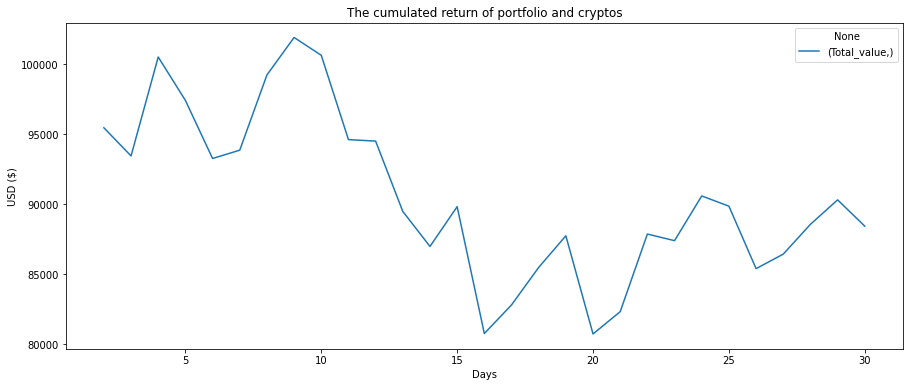

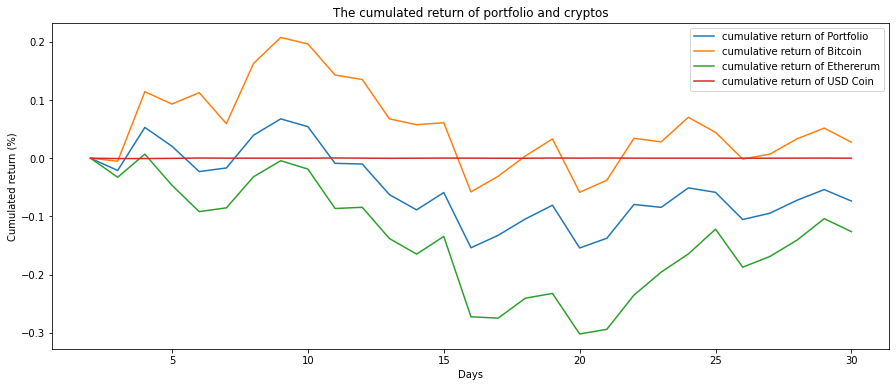

In [325]:
     #| drawing graph start on [x] days
     #V i.e '1' means draw from beginning
draw_graph(1)